In [1]:
import razor
import razor.flow as rf
from razor import api
from razor.flow.spark import SparkBlock, SparkExecutor
import typing as t

In [2]:
import os
from datetime import datetime, timedelta
from pyspark.sql import SparkSession, functions
from pyspark.sql.dataframe import DataFrame
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [3]:
def project_space_path(path):
    ps = api.datasources('Project Space')
    return os.path.join(ps.abspath(), path)


In [4]:
@rf.block
class NonSparkPath:
    # Atomic input - csv filename relative to project space
    ip_path: str
    selected_cols: rf.Output[t.Any]
    # Atomic output of type spark DataFrame.
    op_path: rf.Output[str]
    def run(self):
        self.op_path.put(project_space_path(self.ip_path))
        
@rf.block
class NonSparkCols:
    cols_list: t.Any
    # Atomic input - csv filename relative to project space
    selected_cols: rf.Output[t.Any]
    # Atomic output of type spark DataFrame.
    def run(self):
        self.selected_cols.put(self.cols_list)
        
        

In [5]:
@rf.block
class ReadCsvProjectSpace(SparkBlock):
    filename:str
    data: rf.Output[DataFrame]
    def run(self):
        df = self.spark.read.csv(self.filename, header = True)
        print("Data Schema")
        df.printSchema()
        self.data.put(df)
        

@rf.block
class SelectData(SparkBlock):
    wanted_cols: t.Any
    inputData: DataFrame
    outputData: rf.Output[DataFrame]
    def run(self):
        df = self.inputData
        df_selected = df.select(self.wanted_cols)
        df_selected.show()
        self.outputData.put(df_selected)
        
        
        
@rf.block
class ConcatData(SparkBlock):
    inputData_1: DataFrame
    inputData_2: DataFrame
    outputData: rf.Output[DataFrame]
    def run(self):
        df_concat = self.inputData_1.union(self.inputData_1)
        print("Concat Data")
        df_concat.show()
        self.outputData.put(df_concat)
        

@rf.block
class RenameCol(SparkBlock):
    inputData: DataFrame
    col_dic: t.Any
    outputData: rf.Output[DataFrame]
    def run(self):
        df_rename = self.inputData.withColumnRenamed(list(self.col_dic.keys())[0], self.col_dic[list(self.col_dic.keys())[0]])
        df_rename = df_rename.withColumnRenamed(list(self.col_dic.keys())[1], self.col_dic[list(self.col_dic.keys())[1]])
        self.outputData.put(df_rename)
        
        
        


In [6]:
nsp = NonSparkPath(ip_path='df_with_stats.csv')
nsp1 = NonSparkPath(ip_path='train_hatespeech.csv')

nsc = NonSparkCols(cols_list = ['title','label'])
nsc1 = NonSparkCols(cols_list = ['tweet','class'])

rcp = ReadCsvProjectSpace(filename = nsp.op_path, config={}, source="")
rcp1 = ReadCsvProjectSpace(filename = nsp1.op_path, config={}, source="")

sd = SelectData(wanted_cols=nsc.selected_cols, inputData=rcp.data, config={}, source="")
sd1 = SelectData(wanted_cols=nsc1.selected_cols, inputData=rcp1.data, config={}, source="")
rc = RenameCol(inputData=sd1.outputData,col_dic={'tweet': 'title', 'class': 'label'})
cd = ConcatData(inputData_1=sd.outputData,inputData_2=rc.outputData)

# rcp.executor = rf.ProcessExecutor
# sd.executor = rf.ProcessExecutor
# rcp1.executor = rf.ProcessExecutor
# sd1.executor = rf.ProcessExecutor
# rc.executor = rf.ProcessExecutor
# cd.executor = rf.ProcessExecutor

In [7]:
pipe = rf.Pipeline(targets = [cd])

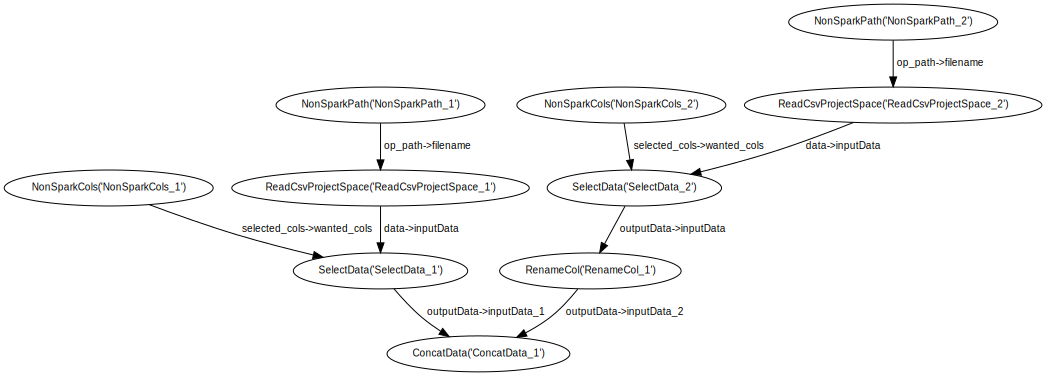

In [8]:
pipe.show()

In [9]:
pipe.execute()

log path: /tmp/tmpb4a5kvoq/Pipeline_1


+--------------------+--------------------+
|               title|               label|
+--------------------+--------------------+
|                null|                null|
| the same newspap...|                null|
|         "" it read.|                null|
|                null|                null|
|                null|                null|
|                null|                null|
|                null|                null|
|                null|                null|
|                null|                null|
|                null|                null|
|                null|                null|
|                null|                null|
|                null|                null|
|                null|                null|
| in Scotland Reut...| Bedfordshire. He...|
|                null|                null|
|           and Lance|                null|
| a film based on ...|Tom Daley,Dustin ...|
|                null|                null|
| thus the series’...|          

{}